In [1]:
import time
import os
from HSSL import *
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_openml


/mnt/large_storage/cabi/hnsw_searchers/HSSL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nX, d = 4_000, 10
X = make_blobs(nX, d, centers=5, random_state=42)[0].astype(np.float32)

gib.graph_based_dendrogram(
            X,
            min_pts = 1,
            symmetric_expand = False,
        )[0]

help(gib.graph_based_dendrogram)

Help on built-in function graph_based_dendrogram in module graphidxbaselines.graphidxbaselines:

graph_based_dendrogram(data, min_pts, expand=None, symmetric_expand=None, higher_max_degree=None, lowest_max_degree=None, max_layers=None, n_parallel_burnin=None, max_build_heap_size=None, max_build_frontier_size=None, level_norm_param_override=None, insert_heuristic=None, insert_heuristic_extend=None, post_prune_heuristic=None, insert_minibatch_size=None, n_rounds=None)



In [2]:
if 1: # Artificial datasets
    nX, d = 4_000, 10
    X = make_blobs(nX, d, centers=5, random_state=42)[0].astype(np.float32)
    # X = np.random.sample((nX, d)).astype(np.float32)
elif 0: # MNIST
    X,_ = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser='liac-arff')
    X = X.astype(np.float32)
    X /= np.sum(X, axis=1, keepdims=True)
    nX, d = X.shape
else: raise ValueError("No dataset selected")
dendrogram = HNSW_HSSL(X, higher_max_degree=15, lowest_max_degree=30, max_build_heap_size=200)
dendrogram = elki_sort_dendrogram(dendrogram)
# roundup_fix_dendrogram(dendrogram)
# plotly_dendrogram(dendrogram, min_size=2, line_width=1, width=3000, height=1000, largest_left=False)

Initializing:   0%|          | 0/4000 [00:00<?, ?it/s]

Merging clusters: 100%|██████████| 3999/3999 [00:18<00:00, 211.27it/s] 


Drawing lines:  15%|█▍        | 1856/12649 [00:00<00:01, 9475.58it/s]

Drawing lines: 100%|██████████| 12649/12649 [00:01<00:00, 10414.17it/s]


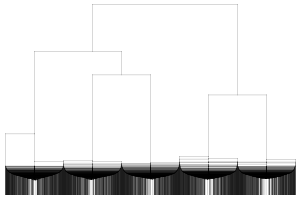

In [3]:
plotly_dendrogram(dendrogram, min_size=50, line_width=.6, width=300, height=200, largest_left=False)

Drawing lines: 100%|██████████| 16239/16239 [00:03<00:00, 4851.15it/s]


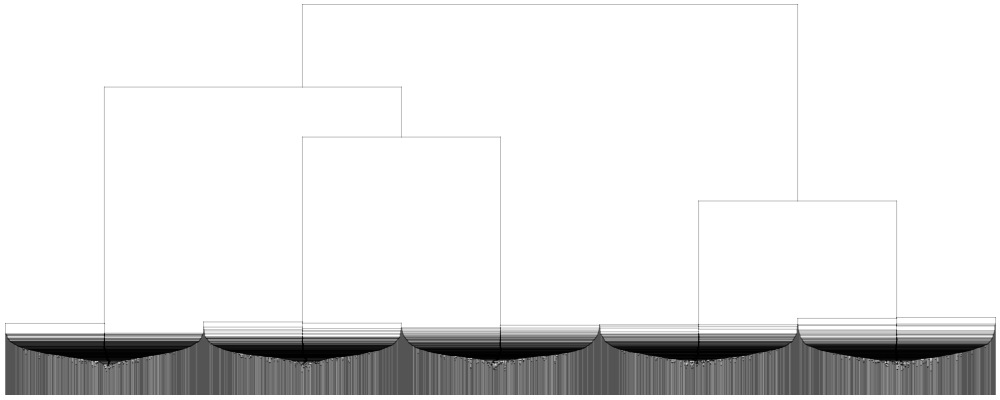

In [4]:
dendrogram = HSSL_Turbo(X, cuda=False, n_trees=10, max_leaf_size=20)
plotly_dendrogram(dendrogram, min_size=2, largest_left=False)

In [5]:
import scipy

H = scipy.cluster.hierarchy.single(X)
H

array([[4.02000000e+02, 1.61000000e+03, 8.18828787e-01, 2.00000000e+00],
       [2.38200000e+03, 3.13600000e+03, 8.45468834e-01, 2.00000000e+00],
       [2.57400000e+03, 3.49800000e+03, 8.83502898e-01, 2.00000000e+00],
       ...,
       [7.98400000e+03, 7.99200000e+03, 1.25030982e+01, 1.60000000e+03],
       [7.99000000e+03, 7.99600000e+03, 1.49323868e+01, 2.40000000e+03],
       [7.99500000e+03, 7.99700000e+03, 1.89432870e+01, 4.00000000e+03]],
      shape=(3999, 4))

HNSW-HDBSCAN computation time: 1.7562851905822754


Drawing lines: 100%|██████████| 16234/16234 [00:03<00:00, 4496.98it/s]


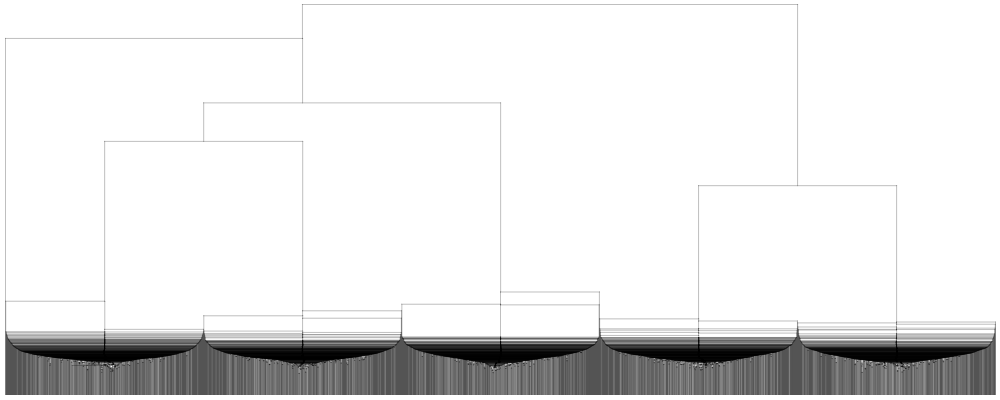

In [6]:
from local_py.bench import benchmark
min_pts = 1
hnsw_time, (hnsw_dendrogram1, core_distances1) = benchmark(
    gib.graph_based_dendrogram,
    X, min_pts, symmetric_expand=True, higher_max_degree=15, lowest_max_degree=30,
)
print("HNSW-HDBSCAN computation time:",hnsw_time)
# Square rooting distances as gib returns squared distance values
hnsw_dendrogram1 = [[a,b,c**.5,d] for a,b,c,d in hnsw_dendrogram1]
plotly_dendrogram(hnsw_dendrogram1, min_size=2, largest_left=False)

Initializing:   4%|▎         | 72/2000 [00:00<00:02, 716.19it/s]

Drawing lines: 100%|██████████| 8114/8114 [00:01<00:00, 4921.13it/s]


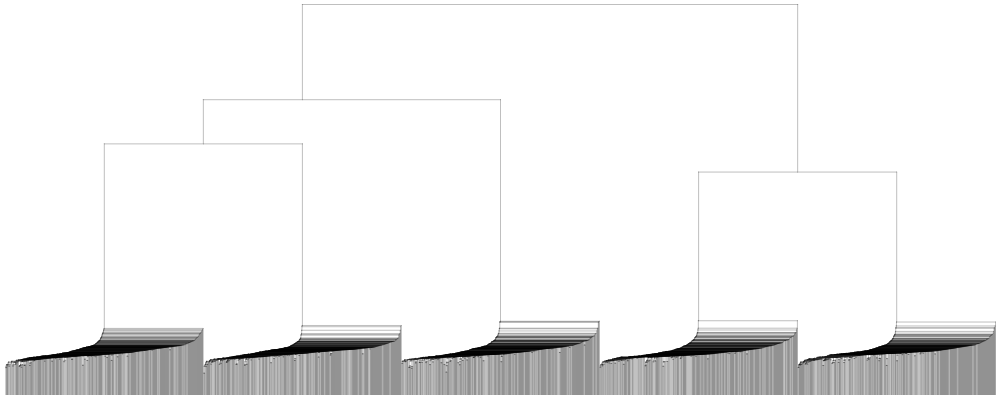

In [7]:
### HSSL_Turbo run ###
np.random.seed(0)
nX, large_d, d = 2_000, 10, 10
X = make_blobs(nX, d, centers=5, random_state=42)[0].astype(np.float32)
if large_d != d:
    rot = np.linalg.eigh(np.cov(np.random.normal(0,1,(large_d, large_d))))[1].astype(np.float32)
    X = X.dot(rot[:d,:])
dendrogram = HSSL_Turbo(X, cuda=False, n_trees=10, max_leaf_size=20)
plotly_dendrogram(dendrogram, min_size=2)

In [8]:
def ensure_folder_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created folder: {path}")
    else:
        print(f"Folder already exists: {path}")

In [9]:
def run_program(algo, dataset_path, model_kwargs):

    with h5py.File(dataset_path, "r") as f:
        data = f['data'][:]

    if algo == "HNSW_HSSL":

        time_start = time.time()
        dendrogram = HNSW_HSSL(data.astype(np.float32), **model_kwargs)
        time_end = time.time()
        total_time = time_end - time_start

    elif algo == "HSSL_Turbo":
        
        time_start = time.time()
        dendrogram = HSSL_Turbo(data, **model_kwargs)
        time_end = time.time()
        total_time = time_end - time_start
    
    else:
        print(f"ERROR - algorithm not supported, available algorithms are: \n HSSL_Turbo, HNSW_HSSL ")
        return
    
    ensure_folder_exists("results/" + dataset_path.split(".hdf5")[0].split("/")[1] + "/" + algo)
    with h5py.File("results/" + dataset_path.split(".hdf5")[0].split("/")[1] + "/" + algo + "/dendro.hdf5", "w") as f:
        f.create_dataset("dendrogram_data", data=dendrogram)
        f.create_dataset("time", data=[total_time])
        f.create_dataset("n", data=[len(data)])
        f.create_dataset("algo", data=[algo])
        # f.create_dataset("params", data=[model_kwargs])

In [10]:
import json

hnsw_args = json.loads("""
{
    "defaults": {
        "max_build_heap_size": 100,
        "higher_max_degree": 20
    },
    "runs": [
        {}
    ]
}
""")

defaults = hnsw_args["defaults"]
runs = hnsw_args["runs"]

print(defaults, runs)

# for i, run in enumerate(runs):
#    print(f"Running config {i+1}...")

#    # Merge default and override
#    hnsw_kwargs = {**defaults, **run}
#    print(hnsw_kwargs)

datasets = ["blobs-2k-10-5.hdf5"
            # "blobs_n=8000_centers=5.hdf5",
            # "blobs_n=16000_centers=5.hdf5", 
            # "blobs_n=32000_centers=5.hdf5",
            # "blobs_n=64000_centers=5.hdf5",
            # "blobs_n=128000_centers=5.hdf5",
            # "mnist.hdf5"
            ]

for dataset in datasets:
    for run in runs:
        hnsw_kwargs = {**defaults, **run}

        run_program("HNSW_HSSL", "data/" + dataset, hnsw_kwargs)

{'max_build_heap_size': 100, 'higher_max_degree': 20} [{}]


Initializing:  27%|██▋       | 540/2000 [00:00<00:00, 1789.19it/s]

Merging clusters: 100%|██████████| 1999/1999 [00:16<00:00, 122.94it/s] 

Folder already exists: results/blobs-2k-10-5/HNSW_HSSL


In [11]:
VP_args = json.loads("""
{
    "defaults": {
        "n_trees": 1,
        "max_leaf_size": 20
    },
    "runs": [
        {}
    ]
}
""")

defaults = VP_args["defaults"]
runs = VP_args["runs"]

print(defaults, runs)

for dataset in datasets:
    VP_kwargs = {**defaults, **run}
    run_program("HSSL_Turbo", "data/" + dataset, VP_kwargs)

{'n_trees': 1, 'max_leaf_size': 20} [{}]


Initializing:   0%|          | 0/2000 [00:00<?, ?it/s]

Merging clusters (1429): 100%|██████████| 1999/1999 [00:16<00:00, 120.80it/s]

Folder already exists: results/blobs-2k-10-5/HSSL_Turbo
